In [1]:

import time
start_time = time.time()
import os
from MultiTimeframeCandleManager import *
from datetime import datetime, timedelta
from collections import deque
import numpy as np
from tqdm import tqdm
import copy
import tensorflow as tf
import random
from save_and_load import *
from Candle import Candle
import matplotlib.pyplot as plt
#from tensorflow.keras import mixed_precision
#mixed_precision.set_global_policy('mixed_float16')


# In[6]:


try:
    cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")
    tf.config.experimental_connect_to_cluster(cluster_resolver)
    tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
    strategy = tf.distribute.TPUStrategy(cluster_resolver)
    print("use tpu strategy")
except:
    strategy = tf.distribute.MirroredStrategy()
strategy



with strategy.scope():
#if True:

  lrelu = tf.keras.layers.LeakyReLU(0.05)


  chart_m15 = tf.keras.layers.Input(shape = (60,4))
  chart_m5 = tf.keras.layers.Input(shape = (60,4))
  chart_m1 = tf.keras.layers.Input(shape = (60,4))

  pdas = tf.keras.layers.Input(shape = (3*3+3*3+1+12*5+5*3,))

  #current_position = tf.keras.layers.Input(shape = (3,))

  minutes = tf.keras.layers.Input(shape = (1,))
  minutes_embed = tf.keras.layers.Embedding(input_dim=60*24, output_dim=8)(minutes)
  minutes_embed_flat = tf.keras.layers.Flatten()(minutes_embed)

  f15 = tf.keras.layers.Flatten()(chart_m15)
  f5 = tf.keras.layers.Flatten()(chart_m5)
  f1 = tf.keras.layers.Flatten()(chart_m1)

  #c = tf.keras.layers.Concatenate()([f15, f5, f1, pdas, minutes_embed_flat, current_position, scaled_open_profit])
  c = tf.keras.layers.Concatenate()([f15, f5, f1, pdas, minutes_embed_flat])

  d = tf.keras.layers.Dense(256)(c)
  d = lrelu(d)
  d = tf.keras.layers.Dense(256)(d)
  d = lrelu(d)
  d = tf.keras.layers.Dense(256)(d)
  d = lrelu(d)
  d = tf.keras.layers.Dense(256)(d)
  d = lrelu(d)


  output = tf.keras.layers.Dense(1, activation="tanh")(d)

  model = tf.keras.Model(inputs = [chart_m15, chart_m5, chart_m1, pdas, minutes], outputs = output)

  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.000001)



model.summary()


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 60, 4)]      0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 60, 4)]      0           []                               
                                                                    

In [2]:
candles = obj_load("NQ_2")

loading NQ_2


In [3]:
m = MultiTimeframeCandleManager()

train_data = []

index = 0

for _ in range(10000):
    ret = m.push_m1_candle(candles[index])
    index += 1

#for _ in tqdm(range(len(candles)-20)):
for _ in tqdm(range(100000)):
    ret = m.push_m1_candle(candles[index])
    midnight_open, midnight_opening_range_high,midnight_opening_range_low, pdas, current_close, current_time, charts = ret


    avg_candle_range = np.mean([ i.h - i.l for i in list(charts[2])])
#avg_candle_range

    slv = avg_candle_range * 3
    tpv = avg_candle_range * 6
    c = m.m1_candles[-1].c

    slshort = c + slv
    tpshort = c - tpv
    sllong = c - slv
    tplong = c + tpv

    short_stop = False
    long_stop = False
    short_hit = False
    long_hit = False

    for index_forward in range(index+1, index+20):
        next_candle = candles[index_forward]
        ncl = next_candle.l
        nch = next_candle.h

        if short_hit == False and ncl < sllong:
            long_stop = True
        if long_hit == False and nch > slshort:
            short_stop = True

        if short_stop == False and ncl < tpshort:
            short_hit = True
        if long_stop == False and nch > tplong:
            long_hit = True

    #print(long_hit, short_hit, short_stop, long_stop)

    x = ret_to_scaled_inputs(ret)
    y = 0
    if long_hit:
        y=1
    if short_hit:
        y=-1

    train_data.append((x,y))

    index += 1

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [01:01<00:00, 1614.95it/s]


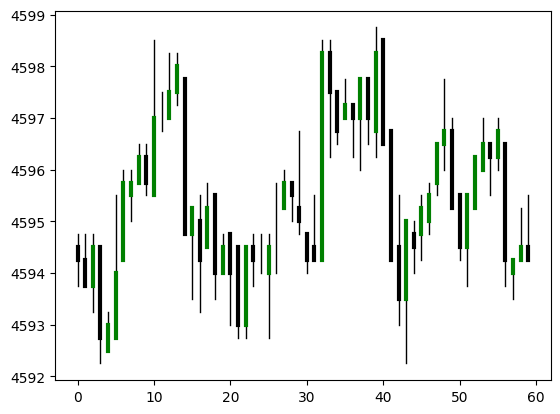

In [4]:
def plot_candles(candles):
    for index in range(len(candles)):
        candle = candles[index]
        c = "green" if candle.c > candle.o else "black"
        plt.plot([index, index], [candle.l, candle.h], linewidth=1, color = "black")
        plt.plot([index, index], [candle.c, candle.o], linewidth=3, color = c)
plot_candles(list(m.m1_candles))


In [5]:

tf.function(jit_compile=False) # my gpu does not support this
def tstep(data):
    x, y = data

    with tf.GradientTape() as t:
        model_return = model(x, training=True)
        #print(y, model_return)
        loss = tf.math.square(y - model_return)
        #print(loss)
        loss = tf.reduce_mean(loss)


    gradient = t.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradient, model.trainable_variables))

    return loss


# In[14]:

batch_size = 512

train_index = 0
def get_data(_):
    global train_index
    train_sample = [train_data[i] for i in range(train_index, train_index + batch_size)]
    train_index += batch_size
    if train_index + batch_size >= len(train_data):
        train_index = 0

    # Extract multiple input features
    states = [x[0] for x in train_sample]  # Extract input features (list of lists)
    states_array = [
        np.array([sample[i] for sample in states], dtype="float32") for i in range(len(states[0]))
    ]  # Convert each input feature to an array

    # Convert to TensorFlow tensors
    states_tensor = [tf.convert_to_tensor(arr) for arr in states_array]

    # Extract targets and convert to tensor
    targets = np.array([x[1] for x in train_sample], dtype="float32")
    targets_tensor = tf.convert_to_tensor(targets)

    return states_tensor, targets_tensor  # Return tuple (list of tensors, labels tensor)


In [9]:
try:
    model.load_weights("model.weights.h5")
except Exception as e:
    print(e)

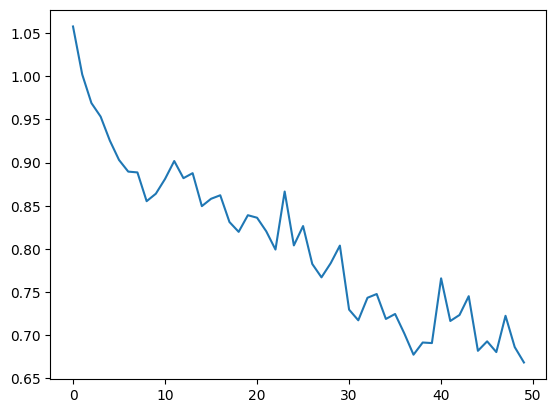

In [7]:
@tf.function
def run(data):
    loss = strategy.reduce(tf.distribute.ReduceOp.MEAN, strategy.run(tstep, args = (data,)), axis = None)
    return loss

import IPython

loss_lt = []

for _ in range(50):
    losses_st = []
    for _ in tqdm(range(1000)):
        distributed_data = (strategy.experimental_distribute_values_from_function(get_data))
        loss = run(distributed_data)
        #print(loss)
        losses_st.append(loss)

    loss_lt.append(np.mean(losses_st))

    IPython.display.clear_output()
    plt.plot(loss_lt)
    plt.show()


In [8]:
model.save_weights("model.weights.h5")
model.save("model.keras")